# Area of study

Wetlands on the peruvian andes

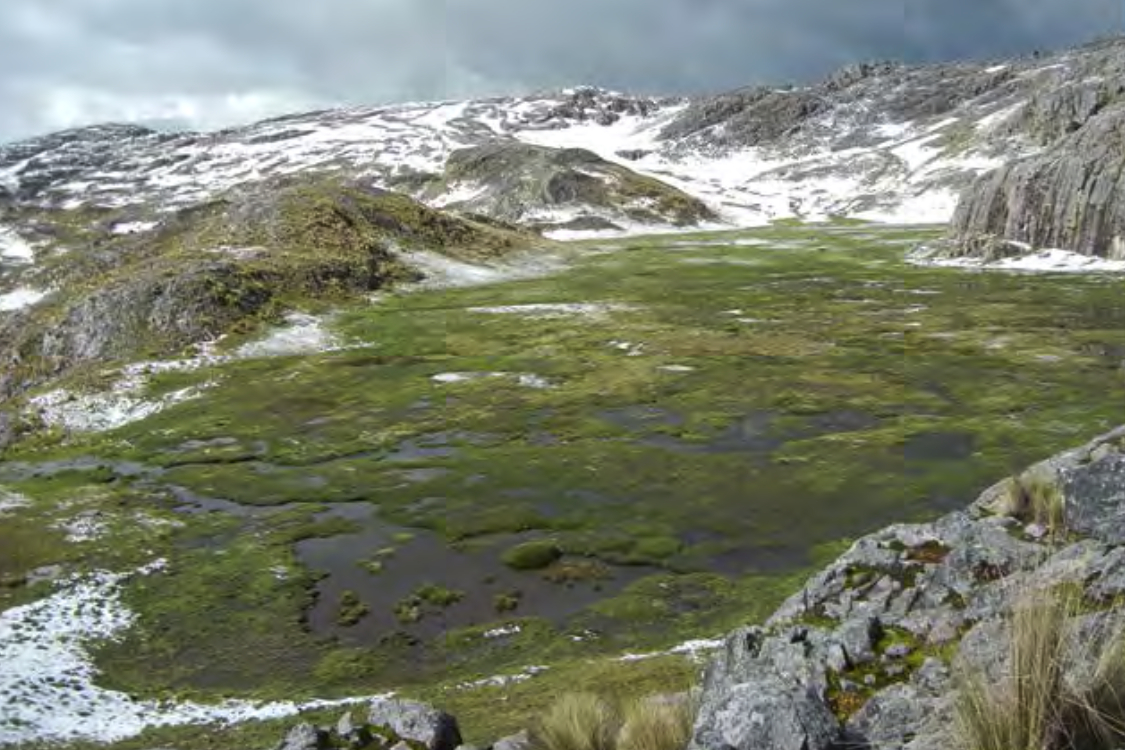

In [1]:
# Photo and data taken from the publication:
# Relationships between aquatic invertebrates, water quality and vegetation in an Andean peatland system
# E. Oyague Passuni and M.S. Maldonado Fonkén, 2015 

from IPython.display import Image
Image("wetlands.png")

<hr/>

# Data import from chemistry and especies

In [2]:
import pandas as pd
import numpy as np

#Import chemistry data
datostemp = pd.read_csv('datosquimica.csv',index_col=0)
datosquimica = datostemp.T

#Import species data
datosespecies = pd.read_csv('datosespecies.csv',index_col=0)

<hr/>

# Generate a dataframe of chemistry with the same index as species

In [3]:
setquimica = datosquimica.reindex(datosespecies.index.tolist()).as_matrix()
setquimica[:,:5]

array([[8.02, 92.9, 7.43, 10.5, 16.9],
       [7.51, 97.7, 7.12, 11.7, 34.9],
       [7.23, 104.2, 4.54, 19.2, 28.1],
       [7.48, 109.8, 3.47, 17.1, 23.3],
       [7.15, 80.6, 8.22, 17.2, 25.6],
       [7.89, 79.6, 8.56, 17.6, 29.6],
       [7.41, 89.0, 7.07, 14.5, 22.4],
       [7.5, 109.5, 8.52, 20.0, 28.9],
       [8.54, 125.1, 4.11, 18.4, 24.6],
       [7.81, 107.8, 7.07, 12.0, 29.5],
       [7.51, 104.8, 7.4, 11.7, 31.8],
       [7.25, 98.7, 4.59, 15.0, 29.2],
       [6.88, 89.8, 3.2, 12.8, 25.3],
       [7.02, 125.1, 6.24, 18.9, 39.4]], dtype=object)

<hr/>

# Chemistry data normalization

Please note we have divided all column by the mean and multiplied by 100 to reduce the error.

In [4]:
import numpy as np
promedio_filas = setquimica.mean(axis=0)
suma_filas = setquimica.sum(axis=0)
setquimica_mean = setquimica / promedio_filas[np.newaxis,:]*100
print setquimica_mean[:3,:3]

[[106.73003802281369 91.94118478721902 118.82567968928485]
 [99.94296577946768 96.69164428106886 113.86794608179116]
 [96.21673003802283 103.12455817899053 72.6068083161983]]


<hr/>

# Define a function of neural networks

In [6]:
from sknn.mlp import Regressor, Layer
def MLP(setquimica,setespecies,neurones,learnrate,niterac):
    valor = ([])
    redneural = Regressor(
        layers=[
            Layer("ExpLin", units=neurones), 
            Layer("ExpLin", units=neurones), Layer("Linear")],
        learning_rate=learnrate,
        n_iter=niterac)
    redneural.fit(setquimica, setespecies)
    for i in range(setquimica.shape[0]):
        prediccion = redneural.predict(np.array([setquimica[i,:].tolist()]))
        valor.append(prediccion[0][0])
    return valor

<hr />

# Create an interactive plot

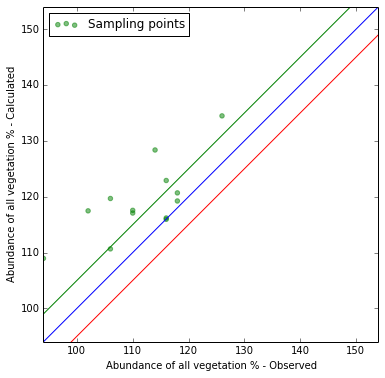

In [7]:
%pylab inline
import matplotlib.pyplot as plt

from ipywidgets import widgets 

def grupored(neurones,learnrate,niterac,especie):
    setespecies = datosespecies.as_matrix()[:,especie]
    igualitario = MLP(setquimica_mean,setespecies,neurones,learnrate,niterac)
    plt.figure(figsize=(6,6))
    plt.scatter(setespecies, igualitario, color='green',alpha=0.5,label='Sampling points')
    plt.plot([0,2000], [0,2000])
    plt.plot([0,2000], [5,2005])
    plt.plot([0,2000], [-5,1995])
    xlim(setespecies.min(),setespecies.max())
    ylim(setespecies.min(),setespecies.max())
    plt.xlabel('Abundance of all vegetation % - Observed')
    plt.ylabel('Abundance of all vegetation % - Calculated')
    plt.legend(loc=2)
    return plt.show()

widgets.interact(grupored,neurones=(400,2000,100),learnrate=(0.00001,0.00002,0.00001)
                 ,niterac=(1,10000,100),especie=1)

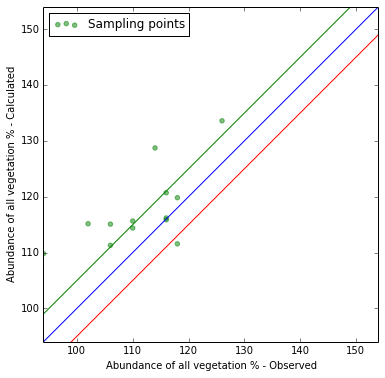

In [9]:
#Finally we keep these parameters
#neurons = 1200
#learning rate = 0.00001
#iterations = 9000
grupored(1200,0.00001,9000,1)

<hr/>

# Now we can predict ecosystem variables

We will do a evaluation on the impact of these three variables:
- pH [0]
- Conductivity [1]
- Dissolved oxygen [2]
- Nitrate (NO3-) [5]

In [10]:
#generate some parameters for the prediction
min_filas = setquimica.min(axis=0)[1]
max_filas = setquimica.max(axis=0)[1]
indices = {'pH':0,
           'Conductivity':1,
           'Dissolved oxygen':2,
           'Nitrate (NO3-)':5}

In [11]:
#run the neural network with the parameters obtained before
from sknn.mlp import Regressor, Layer
redneural = Regressor(
    layers=[
        Layer("ExpLin", units=1200), 
        Layer("ExpLin", units=1200), Layer("Linear")],
    learning_rate=0.00001,
    n_iter=9000)
redneural.fit(setquimica_mean, datosespecies.as_matrix()[:,1])

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `ExpLin`: units=1200, name=u'hidden0', frozen=False>,
     hidden1=<sknn.nn.Layer `ExpLin`: units=1200, name=u'hidden1', frozen=False>,
     layers=[<sknn.nn.Layer `ExpLin`: units=1200, name=u'hidden0', frozen=False>, <sknn.nn.Layer `ExpLin`: units=1200, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=1e-05, learning_rule=u'sgd',
     loss_type=None, n_iter=9000, n_stable=10,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=None, regularize=None, valid_set=None, valid_size=0.0,
     verbose=None, warning=None, weight_decay=None, weights=None)

In [12]:
#function de develop the arrays for the predictions
def generador_norm(parametro):
    distparam = arange(setquimica_mean.min(axis=0)[parametro],setquimica_mean.max(axis=0)[parametro],
                       (setquimica_mean.max(axis=0)[parametro]-setquimica_mean.min(axis=0)[parametro])/10)
    return distparam
def generador_nom(parametro):
    nomparam = arange(setquimica.min(axis=0)[parametro],setquimica.max(axis=0)[parametro],
                       (setquimica.max(axis=0)[parametro]-setquimica.min(axis=0)[parametro])/10)
    return nomparam

## Impact of pH on vegetation abundance

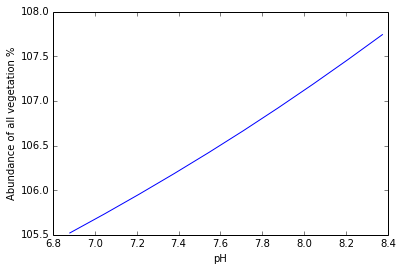

In [13]:
param_norm_generados = generador_norm(indices['pH'])
param_nominales = generador_nom(indices['pH'])
abundacia_ph = []
for valorparam in range(10):
    setquimica_mean[0,:][indices['pH']] = param_norm_generados[valorparam]
    prediccion = redneural.predict(np.array([setquimica_mean[0,:].tolist()]))
    abundacia_ph.append(prediccion[0][0])
import matplotlib.pyplot as plt
plt.plot(param_nominales,abundacia_ph)
plt.xlabel('pH')
plt.ylabel('Abundance of all vegetation %')

## Impact of Conductivity on vegetation abundance

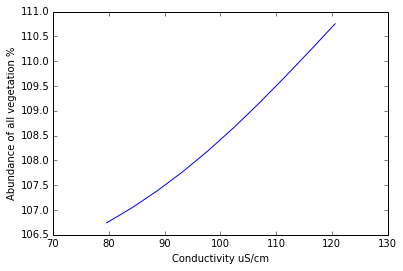

In [14]:
param_norm_generados = generador_norm(indices['Conductivity'])
param_nominales = generador_nom(indices['Conductivity'])
abundacia_cond = []
for valorparam in range(10):
    setquimica_mean[0,:][indices['Conductivity']] = param_norm_generados[valorparam]
    prediccion = redneural.predict(np.array([setquimica_mean[0,:].tolist()]))
    abundacia_cond.append(prediccion[0][0])
import matplotlib.pyplot as plt
plt.plot(param_nominales,abundacia_cond)
plt.xlabel('Conductivity uS/cm')
plt.ylabel('Abundance of all vegetation %')

## Impact of Dissolved Oxygen on vegetation abundance

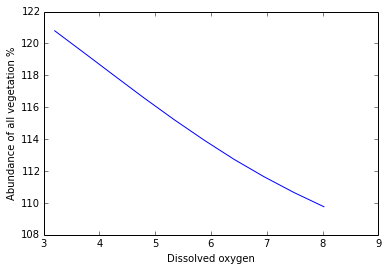

In [15]:
param_norm_generados = generador_norm(indices['Dissolved oxygen'])
param_nominales = generador_nom(indices['Dissolved oxygen'])
abundacia_cond = []
for valorparam in range(10):
    setquimica_mean[0,:][indices['Dissolved oxygen']] = param_norm_generados[valorparam]
    prediccion = redneural.predict(np.array([setquimica_mean[0,:].tolist()]))
    abundacia_cond.append(prediccion[0][0])
import matplotlib.pyplot as plt
plt.plot(param_nominales,abundacia_cond)
plt.xlabel('Dissolved oxygen')
plt.ylabel('Abundance of all vegetation %')

## Impact of Nitrates on vegetation abundance

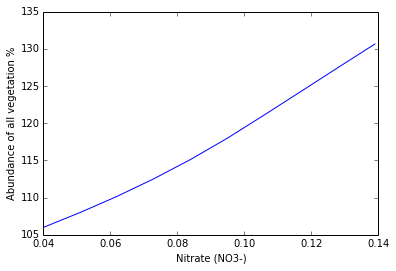

In [16]:
param_norm_generados = generador_norm(indices['Nitrate (NO3-)'])
param_nominales = generador_nom(indices['Nitrate (NO3-)'])
abundacia_cond = []
for valorparam in range(10):
    setquimica_mean[0,:][indices['Nitrate (NO3-)']] = param_norm_generados[valorparam]
    prediccion = redneural.predict(np.array([setquimica_mean[0,:].tolist()]))
    abundacia_cond.append(prediccion[0][0])
import matplotlib.pyplot as plt
plt.plot(param_nominales,abundacia_cond)
plt.xlabel('Nitrate (NO3-)')
plt.ylabel('Abundance of all vegetation %')

<hr/>
# Key Aspects

There are some key aspect to consider in the effectiveness of neural networks. Some of there are:
- Consistent data
- Extensive data records
- Understanding of the governing rules of the phenomenon
- Review of the neural network theory

While considering these aspects, you can enjoy this awesome tool for your everyday work.

For any application of neural networks on a specific field please writo to: <br/>
__saulmontoya@gidahatari.com__